# Point cloud classification with PointNet

**Author:** [David Griffiths](https://dgriffiths3.github.io)<br>
**Date created:** 2020/05/25<br>
**Last modified:** 2020/05/26<br>
**Description:** Implementation of PointNet for ModelNet10 classification.

# Point cloud classification


## Introduction

Classification, detection and segmentation of unordered 3D point sets i.e. point clouds
is a core problem in computer vision. This example implements the seminal point cloud
deep learning paper [PointNet (Qi et al., 2017)](https://arxiv.org/abs/1612.00593). For a
detailed intoduction on PointNet see [this blog
post](https://medium.com/@luis_gonzales/an-in-depth-look-at-pointnet-111d7efdaa1a).


## Setup

If using colab first install trimesh with `!pip install trimesh`.


In [8]:

import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

tf.random.set_seed(1234)


2022-11-30 01:01:17.337101: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
run_type = 'demo'
# run_type = 'full'

## Load dataset

We use the ModelNet10 model dataset, the smaller 10 class version of the ModelNet40
dataset. First download the data:


In [5]:
DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")


We can use the `trimesh` package to read and visualize the `.off` mesh files.


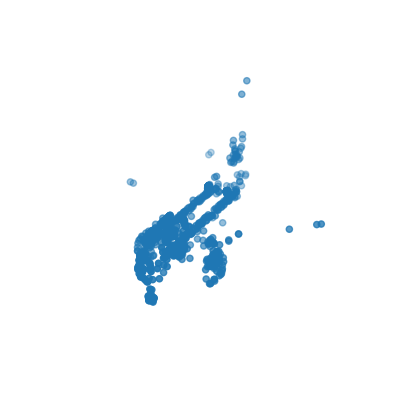

In [21]:
from pyntcloud import PyntCloud
my_point_cloud = PyntCloud.from_file("01.off")
points = my_point_cloud.points.sample(1000).values
points

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()


In [45]:
loc = '../data/multimodal/objectnet3d/ObjectNet3D/CAD/off/aeroplane/01.off'
mesh = trimesh.load(loc)
mesh.show()

In [51]:
loc = '../data/multimodal/objectnet3d/ObjectNet3D/CAD/off/aeroplane/07.off'
mesh = trimesh.load(loc)
mesh.show()

To convert a mesh file to a point cloud we first need to sample points on the mesh
surface. `.sample()` performs a unifrom random sampling. Here we sample at 2048 locations
and visualize in `matplotlib`.


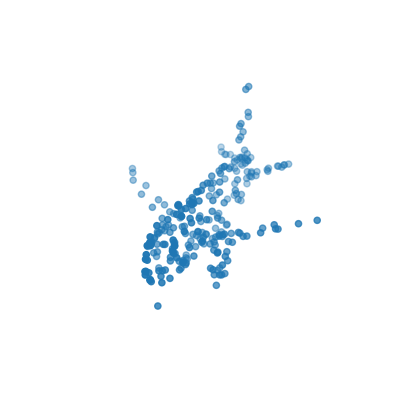

In [28]:
points = mesh.sample(256)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()


In [29]:
DATA_DIR = '/../data/multimodal/objectnet3d/ObjectNet3D/CAD/off/'
mesh = trimesh.load(os.path.join(DATA_DIR, "/aeroplane/train/01.off"))
mesh.show()

ValueError: string is not a file: /aeroplane/train/01.off

In [36]:
mesh = trimesh.load('../data/multimodal/objectnet3d/ObjectNet3D/CAD/off/aeroplane/train/01.off')
mesh.show()

ValueError: string is not a file: ../data/multimodal/objectnet3d/ObjectNet3D/CAD/off/aeroplane/train/01.off

In [34]:
import pandas as pd
pd.read_csv('../data/v2x/intern_data/ambients/trace-NoAttacks.csv')

,rv_id,hv_id,msg_generation_time,msg_rcv_time,msg_count,rv_pos_x,rv_pos_y,rv_pos_z,rv_gps_x,rv_gps_y,...,attack_type,hv_pos_x,hv_pos_y,hv_pos_z,hv_speed,hv_accel,hv_heading,hv_length,hv_width,hv_height
0,57,15,8.67452,8.674663,28,1544.68,3523.870,0,-71.2485,42.3056,...,Genuine,1588.69,3371.340,0,16.65010,0.029701,0.479579,2.1,0.80,1.7
1,15,57,8.68473,8.684868,76,1588.69,3371.340,0,-71.2480,42.3070,...,Genuine,1544.68,3523.870,0,10.11550,2.199580,0.456675,5.0,1.80,1.5
2,57,15,8.77452,8.774673,29,1545.19,3522.980,0,-71.2485,42.3056,...,Genuine,1590.16,3370.580,0,16.62470,-0.254196,0.479579,2.1,0.80,1.7
3,81,63,8.78205,8.782186,0,3287.04,928.818,0,-71.2282,42.3294,...,Genuine,3223.24,884.672,0,3.97215,0.709064,2.696140,12.0,2.50,3.4
4,15,57,8.78473,8.784865,77,1590.16,3370.580,0,-71.2480,42.3070,...,Genuine,1545.19,3522.980,0,10.30550,1.899960,0.723760,5.0,1.80,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9981,87,351,39.99640,39.996523,47,2951.15,1301.870,0,-71.2321,42.3259,...,Genuine,3059.41,1434.450,0,5.48552,-0.305535,1.718590,1.6,0.65,1.7
9982,63,81,39.99670,39.996872,78,3341.02,989.782,0,-71.2275,42.3288,...,Genuine,3324.74,970.663,0,10.46440,0.057891,-0.829529,2.1,0.80,1.7
9983,63,237,39.99670,39.996873,78,3341.02,989.782,0,-71.2275,42.3288,...,Genuine,3119.21,1184.350,0,34.04660,1.499340,-2.332720,5.0,1.80,1.5
9984,267,387,39.99720,39.997383,6,1732.27,3863.350,0,-71.2461,42.3026,...,Genuine,1674.12,3837.710,0,17.90330,1.300000,-0.713938,7.1,2.40,2.4


To generate a `tf.data.Dataset()` we need to first parse through the ModelNet data
folders. Each mesh is loaded and sampled into a point cloud before being added to a
standard python list and converted to a `numpy` array. We also store the current
enumerate index value as the object label and use a dictionary to recall this later.


In [6]:

def parse_dataset(num_points=2048):

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )



Set the number of points to sample and batch size and parse the dataset. This can take
~5minutes to complete.


In [7]:
NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(
    NUM_POINTS
)

processing class: table
processing class: toilet
processing class: bathtub
processing class: monitor
processing class: dresser
processing class: sofa


Our data can now be read into a `tf.data.Dataset()` object. We set the shuffle buffer
size to the entire size of the dataset as prior to this the data is ordered by class.
Data augmentation is important when working with point cloud data. We create a
augmentation function to jitter and shuffle the train dataset.


In [ ]:
# adding extra...

total_training_samples = train_points.shape[0]
total_testing_samples = test_points.shape[0]

random_trainig_indices = np.arange(total_training_samples)
np.random.shuffle(random_trainig_indices)

random_testing_indices = np.arange(total_testing_samples)
np.random.shuffle(random_testing_indices)


print(f"No of training samples: {train_points.shape[0]}")
print(f"No of testing samples: {test_points.shape[0]}")


if run_type == 'demo':
    demo_training_samples = 100
    demo_testing_samples = 100

    random_trainig_indices = random_trainig_indices[0:demo_training_samples]
    random_testing_indices = random_testing_indices[0:demo_testing_samples]

train_points_selected = train_points[random_trainig_indices]
train_labels_selected = train_labels[random_trainig_indices]

test_points_selected = test_points[random_testing_indices]
test_labels_selected = test_labels[random_testing_indices]

print("After updating...")
print(f"No of training samples: {train_points_selected.shape[0]}")
print(f"No of testing samples: {test_points_selected.shape[0]}")

print("Done...!")
print("New...")
print("Hello...!")




In [ ]:
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points_selected, train_labels_selected))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points_selected, test_labels_selected))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)


### Build a model

Each convolution and fully-connected layer (with exception for end layers) consits of
Convolution / Dense -> Batch Normalization -> ReLU Activation.


In [ ]:

def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)



PointNet consists of two core components. The primary MLP network, and the transformer
net (T-net). The T-net aims to learn an affine transformation matrix by its own mini
network. The T-net is used twice. The first time to transform the input features (n, 3)
into a canonical representation. The second is an affine transformation for alignment in
feature space (n, 3). As per the original paper we constrain the transformation to be
close to an orthogonal matrix (i.e. ||X*X^T - I|| = 0).


In [ ]:

class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))



 We can then define a general function to build T-net layers.


In [ ]:

def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])



The main network can be then implemented in the same manner where the t-net mini models
can be dropped in a layers in the graph. Here we replicate the network architecture
published in the original paper but with half the number of weights at each layer as we
are using the smaller 10 class ModelNet dataset.


In [ ]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()


### Train model

Once the model is defined it can be trained like any other standard classification model
using `.compile()` and `.fit()`.


In [ ]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=5, validation_data=test_dataset)


## Visualize predictions

We can use matplotlib to visualize our trained model performance.


In [ ]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()


In [ ]:
print(model.summary())

In [ ]:
from keras.utils.vis_utils import plot_model

In [ ]:
plot_model(model, to_file='plots/pointnet_model_plot.png', show_shapes=True, show_layer_names=True)

In [9]:
import h5py

with h5py.File("../data/mnist3d/train_point_clouds.h5", "r") as hf:    
    a = hf["0"]
    b = hf["1"]    
    digit_a = (a["img"][:], a["points"][:], a.attrs["label"]) 
    digit_b = (b["img"][:], b["points"][:], b.attrs["label"]) 

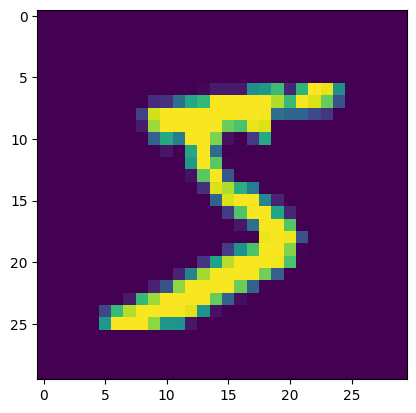

In [10]:
plt.imshow(digit_a[0])

In [13]:
digit_a[1]

array([[ 0.15      , -0.1094358 ,  0.47305447],
       [ 0.15      , -0.0969358 ,  0.47305447],
       [ 0.15      , -0.0844358 ,  0.47305447],
       ...,
       [ 0.15      , -0.1094358 , -0.50194553],
       [ 0.15      , -0.1094358 , -0.51444553],
       [ 0.15      , -0.1094358 , -0.52694553]])

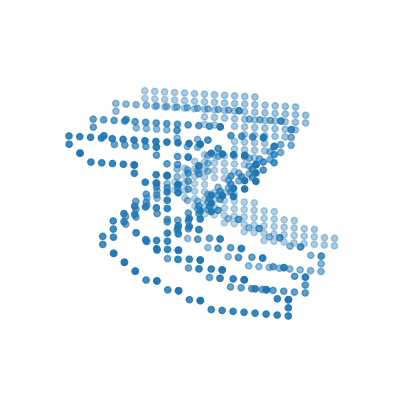

In [35]:
points = digit_a[1][0::50]
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
ax.view_init(15,195)
plt.show()